In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

warnings.filterwarnings('ignore')

# **<u>Results of Static Premier League Scheduling</u>**


Since the goal is to improve the suspense of the premier league, we first have to look at how a static schedule performs.  
This will give us a baseline to compare with and based on these results we can try to see where improvements are possible.  

Besides looking for better schedules by rescheduling, it is also interesting to **`examine how different intial schedules perform even when there is no rescheduling possible`**.



## 1. Load the data 

In [3]:
# basic performance metrics (number lead changes, number relegation changes, average round winner decided)
basic = pd.read_csv('basicMetricsStatic.txt')

# average points difference between teams in the second half of the season (at the time of play)
average_points_difference = pd.read_csv('averagePointsDifferenceStatic.txt')

# number title matches, relegation matches, number irrelevant matches, teams in contention ...... during the last 5 rounds
match_relevance = pd.read_csv('matchRelevanceStatic.txt')

# information about which matches take place in which rounds (in order to find some correlation that can guide our initial optimization strategy)
scheduling = pd.read_csv('schedulingMetricsStatic.txt', sep = ";") 

## 2. Analyzing the suspense of static schedules

The suspsense/attractiveness will mainly be measured by looking at the final 5 rounds.  
For those rounds we will take a look at the number of (ir)relevant matches, but also at the number of teams that are still in the running for certain places (title, champions league, europa league, conference league and relegation).  
We also check the number of times that certain type of matches (title matches, relegation matches, ....) occur and the average points difference between teams in all the matches.

### 2.1 Random Static Schedules
Here we will analyze how random static schedules perform. We obtain the results by making 1000 random schedules and simulating different match outcomes.  
Typical round-robin constraints are included which makes sure that no team has more than two breaks over all the rounds. The schedule of the second half is simply the reverse of the first half. 

#### 2.1.1 Different types of matches during the last 5 rounds

A match is relevant for a team if the **title (top 1)**, **championsleague qualification (top 4)**, **europe league qualification (5-6)**, **conference league qualification (7)** or **relegation (bottom 3**) is dependent on it.   
- **Highly-Relevant matches** are matches that are relevant for both teams.  
- **Partially relevant** matches are matches that are only relevant for one of the teams.   
- **Irrelevant matches** are matches where both teams have nothing at stake.


When making a schedule, the goall will be to either maximize the number of highly-relevant matches or minimize the number of irrelevant matches.  
The assumption for now remains that there exists a tradeoff between the two 

##### 2.1.1.1 Irrelevant matches, relevant matches and partially relevant matches
Start by making a violin plot that shows the distribution of the different types of matches over the last 5 rounds over the 1000 simulations.

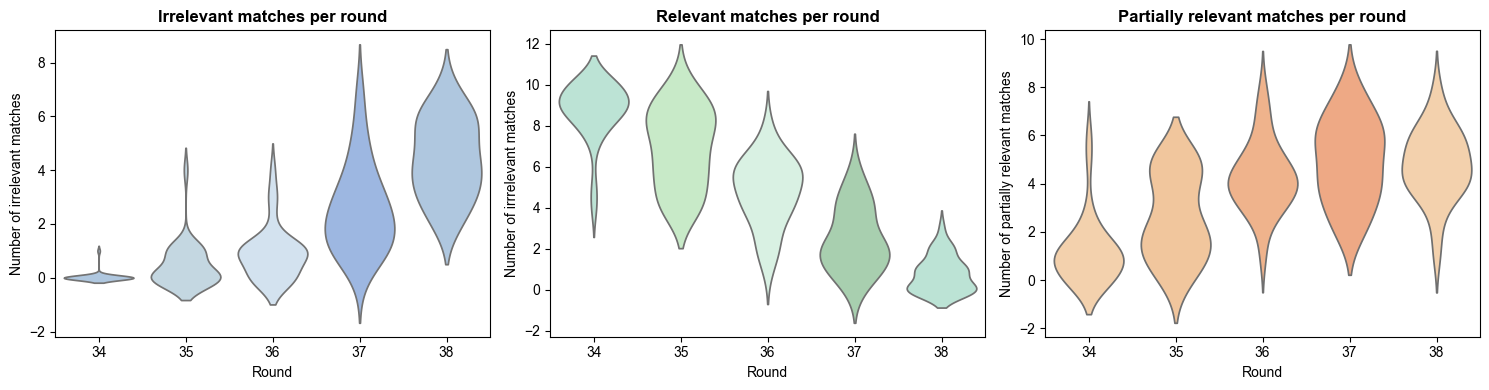

In [4]:

irrelevant_df = match_relevance[[col for col in match_relevance.columns if "irrelevant" in col or "run" in col]]
irrelevant_df_melted = irrelevant_df.melt(id_vars = ["run"])

highly_relevant_df = match_relevance[[col for col in match_relevance.columns if "highly_relevant" in col or "run" in col]]
highly_relevant_df_melted = highly_relevant_df.melt(id_vars = ["run"])

partially_relevant_df = match_relevance[[col for col in match_relevance.columns if "partially" in col or "run" in col]]
partially_relevant_df_melted = partially_relevant_df.melt(id_vars = ["run"])

plt.rcParams['font.family'] = 'Arial'

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Irrelevant matches
sns.violinplot(ax=axes[0], x="variable", y="value", data=irrelevant_df_melted, inner=None, palette=["#A7C7E7", "#BFD8E6", "#CFE2F3", "#92B4EC"]
)
axes[0].set_xlabel("Round")
axes[0].set_ylabel("Number of irrelevant matches")
axes[0].set_title("Irrelevant matches per round", weight = "bold")
axes[0].set_xticks(np.arange(5))
axes[0].set_xticklabels([34, 35, 36, 37, 38])

# Relevant matches
sns.violinplot(ax=axes[1], x="variable", y="value", data=highly_relevant_df_melted, inner=None, palette=["#B5EAD7", "#C2F0C2", "#D5F5E3", "#A2D5AB"])
axes[1].set_xlabel("Round")
axes[1].set_ylabel("Number of irrrelevant matches")
axes[1].set_title("Relevant matches per round", weight = "bold")
axes[1].set_xticks(np.arange(5))
axes[1].set_xticklabels([34, 35, 36, 37, 38])

# Partially relevant matches
sns.violinplot(ax=axes[2], x="variable", y="value", data=partially_relevant_df_melted, inner=None, palette = ["#FFD1A1", "#FFC58F", "#FFB07C", "#FFA474"]
)
axes[2].set_xlabel("Round")
axes[2].set_ylabel("Number of partially relevant matches")
axes[2].set_title("Partially relevant matches per round", weight = "bold")
axes[2].set_xticks(np.arange(5))
axes[2].set_xticklabels([34, 35, 36, 37, 38])

plt.tight_layout()
plt.show()

Plot the expected values to get a clear overview of what we can expect in each round

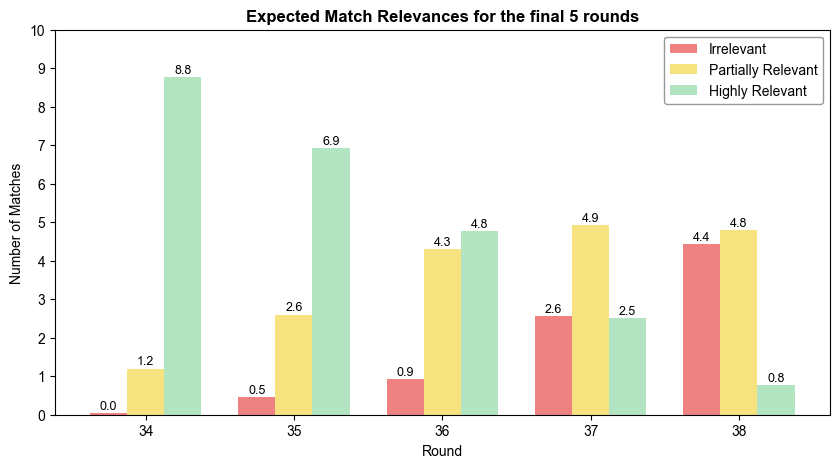

In [ ]:
# Calculate the expected values for each type of match per round
expected_irrelevant = [
    match_relevance["irrelevant_matches_round_34"].mean(),
    match_relevance["irrelevant_matches_round_35"].mean(),
    match_relevance["irrelevant_matches_round_36"].mean(),
    match_relevance["irrelevant_matches_round_37"].mean(),
    match_relevance["irrelevant_matches_round_38"].mean()
]

expected_partially_relevant = [
    match_relevance["partially_relevant_matches_round_34"].mean(),
    match_relevance["partially_relevant_matches_round_35"].mean(),
    match_relevance["partially_relevant_matches_round_36"].mean(),
    match_relevance["partially_relevant_matches_round_37"].mean(),
    match_relevance["partially_relevant_matches_round_38"].mean()
]

expected_relevant = [
    match_relevance["highly_relevant_matches_round_34"].mean(),
    match_relevance["highly_relevant_matches_round_35"].mean(),
    match_relevance["highly_relevant_matches_round_36"].mean(),
    match_relevance["highly_relevant_matches_round_37"].mean(),
    match_relevance["highly_relevant_matches_round_38"].mean()
]

# Create the side-by-side bar plot
rounds = np.arange(len(expected_irrelevant))
bar_width = 0.25

plt.rcParams['font.family'] = 'Arial'


fig, ax = plt.subplots(figsize=(10, 5))

# Plot the bars
p1 = ax.bar(rounds - bar_width, expected_irrelevant, bar_width, label='Irrelevant', color='#ee8283')
p2 = ax.bar(rounds, expected_partially_relevant, bar_width, label='Partially Relevant', color='#f6e27f')
p3 = ax.bar(rounds + bar_width, expected_relevant, bar_width, label='Highly Relevant', color='#b3e4c2')

# Add labels and title
ax.set_xlabel('Round')
ax.set_ylabel('Number of Matches')
ax.set_title('Expected Match Relevances for the final 5 rounds', fontweight = 'bold')
ax.set_xticks(rounds)
ax.set_xticklabels([34, 35, 36, 37, 38])
plt.yticks(np.arange(0, 11, 1))


ax.legend(fontsize=10, loc='upper right', frameon=True, facecolor='white', edgecolor='gray', framealpha=0.8)

plt.show()

Let's now see who the teams with nothing to play for anymore are playing in the final rounds

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define expected values
expected_title_vs_no_stakes = [
    match_relevance["title_vs_no_stakes_matches_round_34"].mean(),
    match_relevance["title_vs_no_stakes_matches_round_35"].mean(),
    match_relevance["title_vs_no_stakes_matches_round_36"].mean(),
    match_relevance["title_vs_no_stakes_matches_round_37"].mean(),
    match_relevance["title_vs_no_stakes_matches_round_38"].mean()
]

expected_champions_league_vs_no_stakes = [
    match_relevance["champions_league_vs_no_stakes_matches_round_34"].mean(),
    match_relevance["champions_league_vs_no_stakes_matches_round_35"].mean(),
    match_relevance["champions_league_vs_no_stakes_matches_round_36"].mean(),
    match_relevance["champions_league_vs_no_stakes_matches_round_37"].mean(),
    match_relevance["champions_league_vs_no_stakes_matches_round_38"].mean()
]

expected_europe_vs_no_stakes = [
    match_relevance["europe_vs_no_stakes_matches_round_34"].mean(),
    match_relevance["europe_vs_no_stakes_matches_round_35"].mean(),
    match_relevance["europe_vs_no_stakes_matches_round_36"].mean(),
    match_relevance["europe_vs_no_stakes_matches_round_37"].mean(),
    match_relevance["europe_vs_no_stakes_matches_round_38"].mean()
]

expected_conference_vs_no_stakes = [
    match_relevance["conference_vs_no_stakes_matches_round_34"].mean(),
    match_relevance["conference_vs_no_stakes_matches_round_35"].mean(),
    match_relevance["conference_vs_no_stakes_matches_round_36"].mean(),
    match_relevance["conference_vs_no_stakes_matches_round_37"].mean(),
    match_relevance["conference_vs_no_stakes_matches_round_38"].mean()
]

expected_relegation_vs_no_stakes = [
    match_relevance["relegation_vs_no_stakes_matches_round_34"].mean(),
    match_relevance["relegation_vs_no_stakes_matches_round_35"].mean(), 
    match_relevance["relegation_vs_no_stakes_matches_round_36"].mean(), 
    match_relevance["relegation_vs_no_stakes_matches_round_37"].mean(), 
    match_relevance["relegation_vs_no_stakes_matches_round_38"].mean(), 
]

# Define plot settings
plt.rcParams['font.family'] = 'Arial'
pastel_colors = ["#ff8fab", "#fcf6bd", "#b9fbc0", "#cddafd", "#ffac81", "#c8a4e7"]

rounds = np.arange(len(expected_europe_vs_no_stakes))
bar_width = 0.2

fig, ax = plt.subplots(figsize=(10, 5))

# Plot bars correctly
p1 = ax.bar(rounds - 2 * bar_width, expected_title_vs_no_stakes, bar_width, label='Title Matches', color=pastel_colors[0])
p2 = ax.bar(rounds - 1 * bar_width, expected_champions_league_vs_no_stakes, bar_width, label='Champions League Matches', color=pastel_colors[1])
p3 = ax.bar(rounds +  0* bar_width, expected_europe_vs_no_stakes, bar_width, label='Europe Matches', color=pastel_colors[2])
p4 = ax.bar(rounds + 1 * bar_width, expected_conference_vs_no_stakes, bar_width, label='Conference Matches', color=pastel_colors[3])
p5 = ax.bar(rounds + 2 * bar_width, expected_relegation_vs_no_stakes, bar_width, label='Conference Matches', color=pastel_colors[5])

# Add labels and title
ax.set_xlabel('Round')
ax.set_ylabel('Number of Matches')
ax.set_title('Different Types of Matches During the Last Rounds', weight='bold')
ax.set_xticks(rounds)
ax.set_xticklabels([34, 35, 36, 37, 38])
ax.set_yticks(np.arange(0, max(max(expected_title_vs_no_stakes), max(expected_champions_league_vs_no_stakes),
                               max(expected_europe_vs_no_stakes), max(expected_conference_vs_no_stakes)) + 1, 1))

ax.legend(fontsize=10, loc='upper left', frameon=True, facecolor='white', edgecolor='gray', framealpha=0.8)

plt.show()


NameError: name 'match_relevance' is not defined

In [ ]:
data = {
    "Round": [34, 35, 36, 37, 38],
    "Title_vs_No_Stakes": expected_title_vs_no_stakes,
    "Champions_League_vs_No_Stakes": expected_champions_league_vs_no_stakes,
    "Europe_vs_No_Stakes": expected_europe_vs_no_stakes,
    "Conference_vs_No_Stakes": expected_conference_vs_no_stakes,
    "Relegation vs no Stakes": expected_relegation_vs_no_stakes
}

# Create DataFrame
df = pd.DataFrame(data)

#### 2.1.1.2 Interest differences in later rounds
We make a distinguishment between 

- **title matches**  
 (both teams still competing for the title)
 <br>

- **champions league matches**  
(both teams still fighting for champions league tickets)
<br>

- **relegation matches**  
(both teams fighting against relegation)
<br>

<br>

Plot the different type of matches over the last 5 rounds

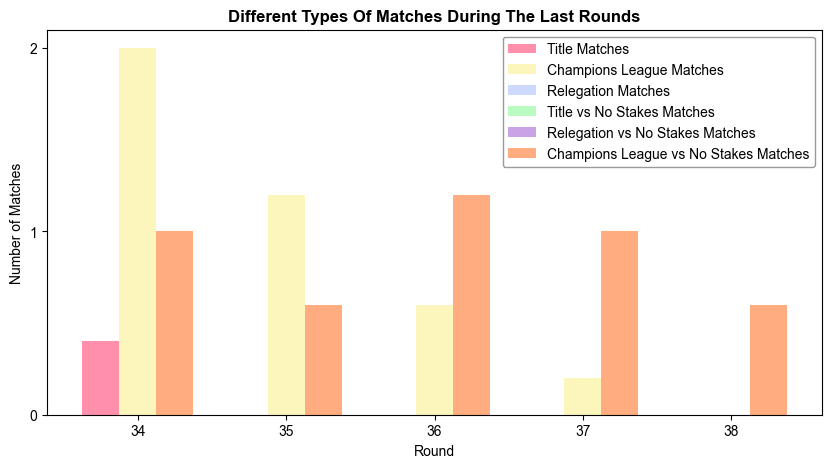

In [ ]:

expected_title_matches = [
    match_relevance["title_matches_round_34"].mean(),
    match_relevance["title_matches_round_35"].mean(),
    match_relevance["title_matches_round_36"].mean(),
    match_relevance["title_matches_round_37"].mean(),
    match_relevance["title_matches_round_38"].mean()
]

expected_champions_league_matches = [
    match_relevance["champions_league_matches_round_34"].mean(),
    match_relevance["champions_league_matches_round_35"].mean(),
    match_relevance["champions_league_matches_round_36"].mean(),
    match_relevance["champions_league_matches_round_37"].mean(),
    match_relevance["champions_league_matches_round_38"].mean()
]

expected_relegation_matches = [
    match_relevance["relegation_matches_round_34"].mean(),
    match_relevance["relegation_matches_round_35"].mean(),
    match_relevance["relegation_matches_round_36"].mean(),
    match_relevance["relegation_matches_round_37"].mean(),
    match_relevance["relegation_matches_round_38"].mean()
]


expected_title_vs_no_stakes_matches =  [
    match_relevance["title_vs_no_stakes_matches_round_34"].mean(),
    match_relevance["title_vs_no_stakes_matches_round_35"].mean(),
    match_relevance["title_vs_no_stakes_matches_round_36"].mean(),
    match_relevance["title_vs_no_stakes_matches_round_37"].mean(),
    match_relevance["title_vs_no_stakes_matches_round_38"].mean()
]


expected_champions_league_vs_no_stakes_matches = [
    match_relevance["champions_league_vs_no_stakes_matches_round_34"].mean(),
    match_relevance["champions_league_vs_no_stakes_matches_round_35"].mean(),
    match_relevance["champions_league_vs_no_stakes_matches_round_36"].mean(),
    match_relevance["champions_league_vs_no_stakes_matches_round_37"].mean(),
    match_relevance["champions_league_vs_no_stakes_matches_round_38"].mean()
]


expected_relegation_vs_no_stakes_matches = [
    match_relevance["relegation_vs_no_stakes_matches_round34"].mean(),
    match_relevance["relegation_vs_no_stakes_matches_round35"].mean(),
    match_relevance["relegation_vs_no_stakes_matches_round36"].mean(),
    match_relevance["relegation_vs_no_stakes_matches_round37"].mean(),
    match_relevance["relegation_vs_no_stakes_matches_round38"].mean()
]

plt.rcParams['font.family'] = 'Arial'
pastel_colors = ["#ff8fab", "#fcf6bd", "#b9fbc0", "#cddafd", "#ffac81", "#c8a4e7"]

rounds = np.arange(len(expected_title_matches))
bar_width = 0.25

fig, ax = plt.subplots(figsize=(10, 5))

# Plot the bars
p1 = ax.bar(rounds - bar_width, expected_title_matches, bar_width, label='Title Matches', color= pastel_colors[0])
p2 = ax.bar(rounds, expected_champions_league_matches, bar_width, label='Champions League Matches', color= pastel_colors[1])
p4 = ax.bar(rounds + bar_width, expected_relegation_matches, bar_width, label='Relegation Matches', color = pastel_colors[3])
p3 = ax.bar(rounds + bar_width, expected_title_vs_no_stakes_matches, bar_width, label='Title vs No Stakes Matches', color = pastel_colors[2])
p5 = ax.bar(rounds + bar_width, expected_relegation_vs_no_stakes_matches, bar_width, label='Relegation vs No Stakes Matches', color = pastel_colors[5])
p6 = ax.bar(rounds + bar_width, expected_champions_league_vs_no_stakes_matches, bar_width, label='Champions League vs No Stakes Matches', color = pastel_colors[4])


# Add labels and title
ax.set_xlabel('Round')
ax.set_ylabel('Number of Matches')
ax.set_title('Different Types Of Matches During The Last Rounds', weight = 'bold')
ax.set_xticks(rounds)
ax.set_xticklabels([34, 35, 36, 37, 38])
plt.yticks(np.arange(0, 3, 1))
ax.legend(fontsize=10, loc='upper right', frameon=True, facecolor='white', edgecolor='gray', framealpha=0.8)


#### Let's examine when on average the certain places are fixed and there is nothing to play for anyomore 

#### 2.1.2 Teams in the running for different places

Plot the number of teams that are expected to be in the running for different places before any of the last 5 rounds

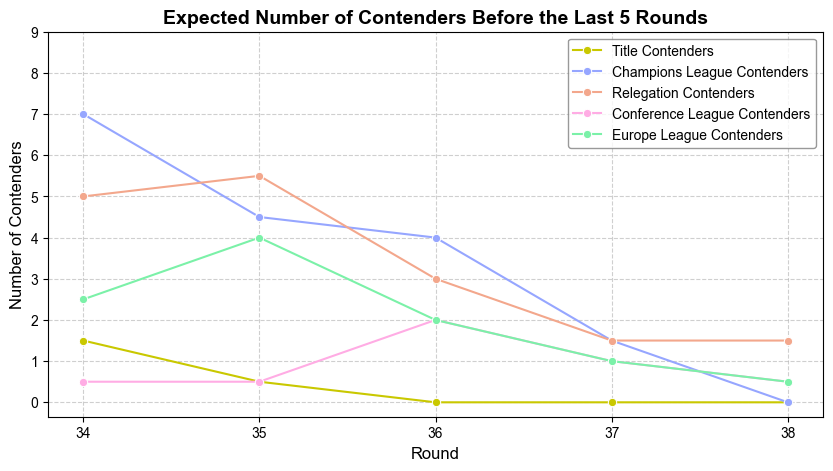

In [103]:
title_runners_mean = match_relevance[[col for col in match_relevance.columns if "title_contenders" in col]]
title_runners_mean = title_runners_mean.mean(axis = 0).reset_index()[0]

champions_league_runners_mean = match_relevance[[col for col in match_relevance.columns if "champions_league_contenders" in col]]
champions_league_runners_mean = champions_league_runners_mean.mean(axis = 0).reset_index()[0]

europe_league_contenders_mean =  match_relevance[[col for col in match_relevance.columns if "europe_league_contenders" in col]]
europe_league_contenders_mean = europe_league_contenders_mean.mean(axis = 0).reset_index()[0]

conference_league_contenders_mean = match_relevance[[col for col in match_relevance.columns if "conference_league_contenders" in col]]
conference_league_contenders_mean = conference_league_contenders_mean.mean(axis = 0).reset_index()[0]


relegation_runners_mean = match_relevance[[col for col in match_relevance.columns if "relegation_contenders" in col]]
relegation_runners_mean = relegation_runners_mean.mean(axis = 0).reset_index()[0]


no_contenders_mean = match_relevance[[col for col in match_relevance.columns if "no_contenders" in col]]
no_contenders_mean = no_contenders_mean.mean(axis = 0).reset_index()[0]


# Ensure Arial font is used
plt.rcParams['font.family'] = 'Arial'

# Define pastel color palette
pastel_colors = ["#c9c800", "#96a6ff", "#f3a78c", "#bfa2d7", "#fface4", "#7bf1a8"]
# Create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Round': [34, 35, 36, 37, 38],
    'Title Contenders': title_runners_mean,
    'Champions League Contenders': champions_league_runners_mean,
    'Relegation Contenders': relegation_runners_mean,
    'No Stakes': no_contenders_mean,
    'Europe League Contenders': europe_league_contenders_mean,
    'Conference League Contenders': conference_league_contenders_mean
})

# Create figure
plt.figure(figsize=(10, 5))

# Plot with pastel colors
sns.lineplot(data=plot_data, x='Round', y='Title Contenders', marker='o', label='Title Contenders', color=pastel_colors[0])
sns.lineplot(data=plot_data, x='Round', y='Champions League Contenders', marker='o', label='Champions League Contenders', color=pastel_colors[1])
sns.lineplot(data=plot_data, x='Round', y='Relegation Contenders', marker='o', label='Relegation Contenders', color=pastel_colors[2])
#sns.lineplot(data=plot_data, x='Round', y='No Stakes', marker='o', label='Teams with no stakes', color=pastel_colors[3])
sns.lineplot(data=plot_data, x='Round', y='Conference League Contenders', marker='o', label='Conference League Contenders', color=pastel_colors[4])
sns.lineplot(data=plot_data, x='Round', y='Europe League Contenders', marker='o', label='Europe League Contenders', color=pastel_colors[5])



# Add labels and title
plt.xlabel('Round', fontsize=12)
plt.ylabel('Number of Contenders', fontsize=12)
plt.title('Expected Number of Contenders Before the Last 5 Rounds', fontsize=14, fontweight='bold')

# Adjust legend
plt.legend(fontsize=10, loc='upper right', frameon=True, facecolor='white', edgecolor='gray', framealpha=0.8)

# Set x-ticks and y-ticks
plt.xticks(ticks=[34, 35, 36, 37, 38], fontsize=10)
plt.yticks(ticks=range(0, 10), fontsize=10)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Show plot
plt.show()


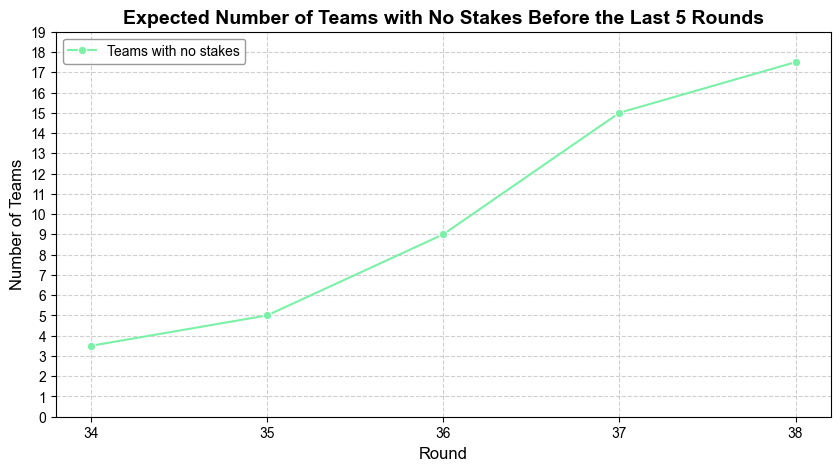

In [106]:
# Create figure
plt.figure(figsize=(10, 5))

sns.lineplot(data=plot_data, x='Round', y='No Stakes', marker='o', label='Teams with no stakes', color=pastel_colors[5])

plt.xlabel('Round', fontsize=12)
plt.ylabel('Number of Teams', fontsize=12)

plt.title('Expected Number of Teams with No Stakes Before the Last 5 Rounds', fontsize=14, fontweight='bold')

plt.legend(fontsize=10, loc='upper left', frameon=True, facecolor='white', edgecolor='gray', framealpha=0.8)

plt.xticks(ticks=[34, 35, 36, 37, 38], fontsize=10)
plt.yticks(ticks=range(0, 20), fontsize=10)

plt.grid(True, linestyle='--', alpha=0.6)



Plot the number of teams that are already certain of there positioning for each group over time

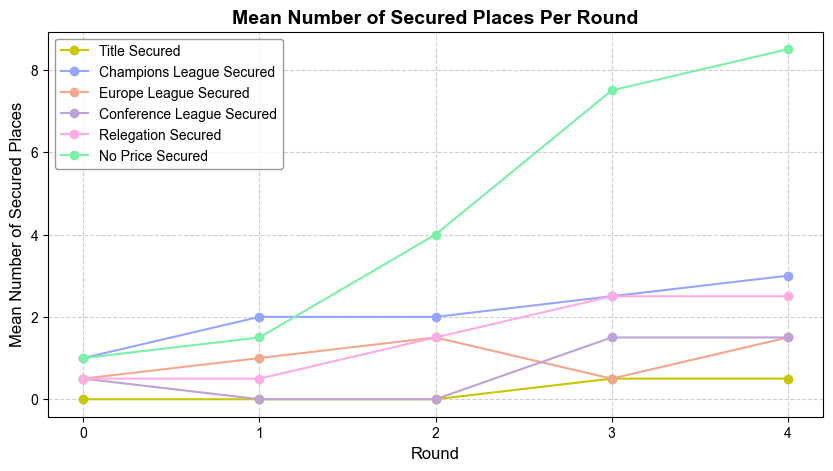

In [107]:
match_relevance = pd.read_csv('matchRelevanceStatic.txt')
match_relevance.head()

confirmed_places = match_relevance[[col for col in match_relevance.columns if "secured" in col]]
confirmed_places.columns

title_secured_mean = dict(confirmed_places[[col for col in confirmed_places.columns if "title" in col]].mean(axis = 0))
champions_league_secured_mean = dict(confirmed_places[[col for col in confirmed_places.columns if "champions_league" in col]].mean(axis = 0))
relegation_secured_mean = dict(confirmed_places[[col for col in confirmed_places.columns if "relegation" in col]].mean(axis = 0))
europe_league_secured_mean = dict(confirmed_places[[col for col in confirmed_places.columns if "europe_league" in col]].mean(axis = 0))
conference_league_secured_mean = dict(confirmed_places[[col for col in confirmed_places.columns if "conference_league" in col]].mean(axis = 0))
no_price_secured_mean = dict(confirmed_places[[col for col in confirmed_places.columns if "no_price" in col]].mean(axis = 0))


rounds = np.arange(5)

# Plot the mean number of secured places per round for all the different categories as a line chart
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each category
ax.plot(rounds, title_secured_mean.values(), marker='o', label='Title Secured', color=pastel_colors[0])
ax.plot(rounds, champions_league_secured_mean.values(), marker='o', label='Champions League Secured', color=pastel_colors[1])
ax.plot(rounds, europe_league_secured_mean.values(), marker='o', label='Europe League Secured', color=pastel_colors[2])
ax.plot(rounds, conference_league_secured_mean.values(), marker='o', label='Conference League Secured', color=pastel_colors[3])
ax.plot(rounds, relegation_secured_mean.values(), marker='o', label='Relegation Secured', color=pastel_colors[4])
ax.plot(rounds, no_price_secured_mean.values(), marker='o', label='No Price Secured', color=pastel_colors[5])

# Add labels, title, and legend
ax.set_xlabel('Round', fontsize=12)
ax.set_ylabel('Mean Number of Secured Places', fontsize=12)
ax.set_title('Mean Number of Secured Places Per Round', fontsize=14, fontweight='bold')
ax.set_xticks(rounds)
ax.legend(fontsize=10, loc='upper left', frameon=True, facecolor='white', edgecolor='gray', framealpha=0.8)

# Add grid for better readability
ax.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [108]:
mean_list = [title_secured_mean, champions_league_secured_mean, europe_league_secured_mean, conference_league_secured_mean, relegation_secured_mean, no_price_secured_mean]

# take the last value out of each dictionary in the list and sum it 
total_secured_places = sum([list(d.values())[-1] for d in mean_list])

total_secured_places

np.float64(17.5)

### 2.2 Well-chosen Static Schedules
Here we will see what happens when we make a certain schedule at the beginning of the season where we already try to influence the suspsense at the end.  
There will however be no rescheduling during the season.  
In this case we also assume that we have **access to the ratings of the teams**

## 3. Examining Correlations between the schedules and the results

We recorded when the teams played against each other in the second half, so maybe we can use this to get some insights into what scheduling rules will give us better performances  
**`Update: No correlations present`**   

Let's take a look into more detail at the rounds in which we see that there are not a lot of irrelevant matches to see if we can find some hidden patterns 

In [ ]:
dependent_variable = pd.DataFrame(match_relevance["irrelevant_matches_round_38"])
dependent_variable.rename(columns = {"0": "dependent"}, inplace = True)
dependent_variable.head()

,irrelevant_matches_round_38
0,5
1,7
2,2
3,4
4,6


In [ ]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators=100, random_state=42)
features = scheduling.drop(columns = "run")
clf.fit(features, dependent_variable)
    

ValueError: Found input variables with inconsistent numbers of samples: [1000, 5]

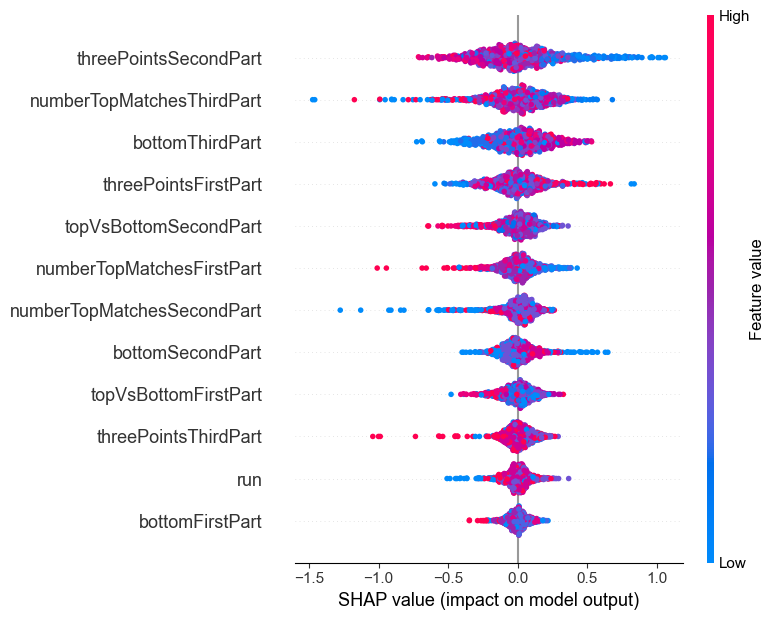

In [ ]:
import shap

# Create SHAP explainer
explainer = shap.TreeExplainer(clf)

# Compute Shapley values
shap_values = explainer.shap_values(features)

# Plot feature importance
shap.summary_plot(shap_values, features=features, feature_names=scheduling.columns)

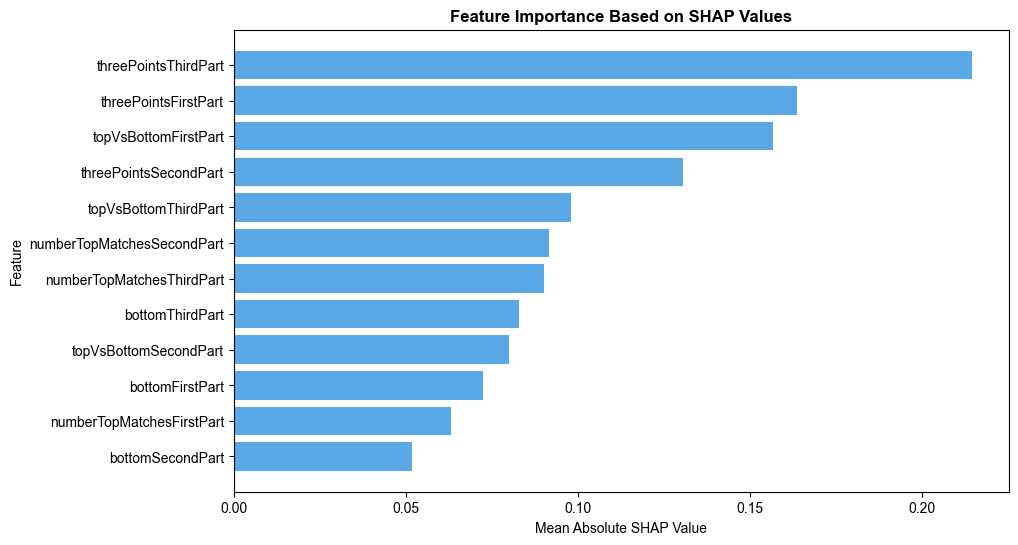

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'Arial'


# Compute mean absolute SHAP values per feature
feature_importance = np.abs(shap_values).mean(axis=0)

# Convert to DataFrame for better visualization
feature_importance_df = pd.DataFrame(
    {'Feature': features.columns, 'Mean SHAP Value': feature_importance}
).sort_values(by="Mean SHAP Value", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Mean SHAP Value'], color = "#5aa9e6") 
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature')
plt.title('Feature Importance Based on SHAP Values', fontweight = 'bold')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
import pandas as pd
shap_df = pd.DataFrame(shap_values, columns=features.columns)
correlations = shap_df.corrwith(features)
correlations.sort_values()


threePointsSecondPart        -0.352101
bottomFirstPart              -0.303750
topVsBottomThirdPart         -0.258099
threePointsThirdPart         -0.249382
topVsBottomFirstPart         -0.173119
numberTopMatchesThirdPart    -0.083737
numberTopMatchesFirstPart    -0.070386
bottomSecondPart              0.020724
threePointsFirstPart          0.026373
numberTopMatchesSecondPart    0.128866
bottomThirdPart               0.195739
topVsBottomSecondPart         0.364659
dtype: float64

## Dynamic Results